# SIMULACIÓ DE QUANTUM ANNEALING
Robert Vila Alsina,

Primavera 2023

Pràctiques d'empresa, tutors: Bruno Julià i Carles Calero

## Quantum Annealing

Aquesta forma de computació quàntica utilitza el Teorema Adiabàtic per a evolucionar el Hamiltonià d'un conjunt de qubits en el temps fins a trobar l'estat de mínima energia. Al principi, s'aplica un camp molt fort en la direcció transversal x que força els spins cap a una direcció. El camp transversal es va reduint de forma adiabàtica i al final obtenim el ground state. 

L'Hamiltonià del sistema es pot expressar:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

La idea és començar amb una $\Gamma (t)$ molt gran i anar-la reduïnt poc a poc, de manera adabàtica. Això correspon al camp transversal x que apliquem als qubits. Després de l'evolució, l'únic terme que quedarà serà el $\mathcal{H}_0$, que ens permetrà trobar quina és l'energia associada al groundstate.

La importància d'aquesta tècnica de computació quàntica és que es pot fer servir com a eina per a resoldre problemes d'optimització de combinatòria. Això es pot fer expressant el problema com un Hamiltonià d'un model d'Ising i trobant un anàleg en el conjunt de qubits i les seves connexions. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np


### Nombre d'spins
Elegim el nombre d'spins del sistema N que volem simular

In [2]:
N = 4

### Possibles estats
El nombre d'estats del sistema creix com $2^N$ on N és el nombre de bits del sistema. Això fa que per un nombre mitjanament gran de spins no sigui possible computar tots els estats per a trobar el de mínima energia.


[[-1. -1. -1. -1.]
 [-1. -1. -1.  1.]
 [-1. -1.  1. -1.]
 [-1. -1.  1.  1.]
 [-1.  1. -1. -1.]
 [-1.  1. -1.  1.]
 [-1.  1.  1. -1.]
 [-1.  1.  1.  1.]
 [ 1. -1. -1. -1.]
 [ 1. -1. -1.  1.]
 [ 1. -1.  1. -1.]
 [ 1. -1.  1.  1.]
 [ 1.  1. -1. -1.]
 [ 1.  1. -1.  1.]
 [ 1.  1.  1. -1.]
 [ 1.  1.  1.  1.]]
Tindrem un total de: 16 estats


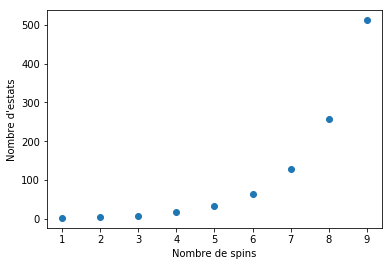

In [3]:
#Fem una matriu amb tots els possibles estats dels spins (2^N)
#En una matriu de N columnes i 2^N files

def matriu_estats(N):
    matriu = np.zeros((2**N,N))
    for i in range(2**N):
        for j in range(N):
            matriu[i,j] = (i // 2**(N-j-1)) % 2
    matriu[matriu == 0] = -1
    return matriu

estats_spins = matriu_estats(N)
print(estats_spins)

print("Tindrem un total de:", len(estats_spins), "estats")

#Grafiquem el nombre d'estats en funció del nombre de spins
x = np.arange(1,10)
y = 2**x
plt.plot(x,y, "o")
plt.xlabel("Nombre de spins")
plt.ylabel("Nombre d'estats")
plt.show()

### Termes d'interacció entre els spins
Per altra banda, la matriu $J_{ij}$ és el patró de interaccions entre els spins. Així, $J_{13}$ mesurarà les interaccions de l'spin 1 amb el 3. Una possible aproximació podria ser considerar que cada spin només interactua amb els dels seu voltant, els primers veïns, de forma que només quedarien diferents de zero la diagonal per sobre de la diagonal principal i la seva simètrica.

En el nostre cas, com que només ens interessa veure com se simula el procés, aleatoritzarem els valors de la matriu. Això ho farem agafant valors d'una distribució Gaussiana de mitjana 0 i desviació estàndard 1.

In [4]:
#Declarem la matriu J d'interacció entre diferents spins
matrix_J = np.random.normal(loc=0, scale=1, size=(N, N))
matrix_J[np.diag_indices(N)] = 0


matrix_J

array([[ 0.        , -0.00693158, -0.31995088,  0.03782606],
       [-0.26881607,  0.        , -0.1210524 ,  0.3364348 ],
       [ 0.02775744, -0.34275796,  0.        , -0.18272845],
       [ 1.37890674, -0.09859783,  0.59005496,  0.        ]])

### Terme d'interacció amb si mateix

També existeix un terme energètic associat al propi spin, $\alpha$. Per exemple, podem posar $\alpha = 1$

In [5]:
#Declarem el terme d'interacció amb si mateix, alpha
alpha = 1
alpha

1

### Hamiltonià inicial del sistema

Amb el nombre d'spins amb el que treballem, podem trobar quin és el ground state abans de simular l'evolució temporal del sistema. Això ho podem fer amb els valors propis. 

El Hamiltonià final del sistema:

$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

On $\sigma_i^z$ és la matriu de Pauli en la direcció z que actua en l'spin i. És important notar que els termes del sumatori tenen productes tensorials per una identitat 2x2 implícits en totes les posicions que no estem aplicant la matriu de Pauli. Per exemple, el terme d'interacció entre els spins 2 i 3 d'un sistema de 5 bits serà:

$$J_{23}( I \otimes \sigma^z \otimes \sigma^z \otimes I \otimes I )$$

Matrius\\

$I =$ 
\begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}\hspace{2cm}

$$ \sigma^z = $$ 

\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\hspace{2cm}

$$\sigma^x =$$ 
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}


Energies de l'estat inicial:  [-3.74359755 -2.99106102 -2.32171034 -1.36053272 -1.32669591 -0.28937029
 -0.28937029 -0.08994977 -0.08994977  0.12291761  0.12291761  1.00893898
  1.67828966  2.63946728  2.67330409  4.25640245]
Vectors propis de l'estat inicial:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0

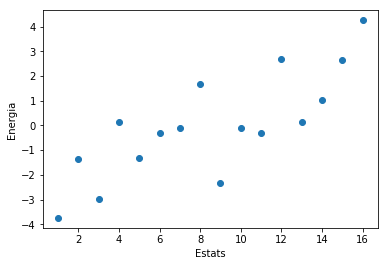

Energia mínima:  -3.743597548429035 Corresponent al ground-state:  1 que és:  [-1. -1. -1. -1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
#Declarem les matrius de Pauli i la identitat
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])
identitat = np.identity(2)

#Calculem les energies del ground state, H0

#Operador Hamiltonià H0
def Ham0():
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ
    return H

H0 = Ham0()

#Calculem les energies del ground state, H0
vals_H0, vecs_H0 = np.linalg.eigh(H0)

print ("Energies de l'estat inicial: ", vals_H0)
print ("Vectors propis de l'estat inicial: ", vecs_H0)
#Trobem un anàleg de l'ordre de les energies amb els estats corresponents
ordre = []
for i in range(2**N):
    num = np.where(vecs_H0[:,i] == 1)[0][0]
    ordre.append(num)


#Grafiquem l'energia H0 per tots els estats possibles
#En un eix el nombre d'estat i en l'altre l'energia
ordremes1 = [i+1 for i in ordre]
plt.plot(ordremes1, vals_H0, "o")
plt.xlabel('Estats')
plt.ylabel('Energia')
plt.show()

print("Energia mínima: ", vals_H0[0], "Corresponent al ground-state: ", ordremes1[0], "que és: ", estats_spins[ordre[0]])

E_min = vals_H0[0]

#Guardem el vector propi corresponent a l'estat amb energia mínima
vec_minH0 = vecs_H0[:,0]
print (vec_minH0)


### Operador Hamiltonià temporal

Com s'ha anunciat al principi, l'operador hamiltonià de la nostra simulació també tindrà un terme que evolucionarà amb el temps. Serà de la forma:

$$ \mathcal{H}(t)=\mathcal{H}_0-\Gamma(t) \sum_i \sigma_i^x $$
on:
$$ \mathcal{H}_0=-\sum_{i,j} J_{i j} \sigma_i^z \sigma_j^z-\alpha \sum_i \sigma_i^z$$

És molt importnant escollir una funció $\Gamma (t)$ que avanci de forma prou lenta com perquè el sistema no salti entre el ground state i els primers excitats. El sistema ha d'evolucionar de forma adiabàtica. Per exemple, nosaltres farem servir:

$$ \Gamma (t) = \frac{10}{1+t}$$


In [7]:


#Operador Hamiltonià
def H(t):
    H = np.zeros((2**N, 2**N))

    #Afegim el terme alpha
    for i in range(N):
        malpha = np.identity(1)
        for j in range(N):
            if j == i:
                malpha = np.kron(malpha, sigma_z)
            else:
                malpha = np.kron(malpha, identitat)
        H -= alpha*malpha

    #Afegim el terme J
    for i in range(N-1):
        for j in range(i,N):
            mJ = np.identity(1)
            for k in range(N):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H -= matrix_J[i,j]*mJ

    #Afegim el terme gamma
    gamma = 10./(t+1.)
    for i in range(N):
        mgamma = np.identity(1)
        for j in range(N):
            if j == i:
                mgamma = np.kron(mgamma, sigma_x)
            else:
                mgamma = np.kron(mgamma, identitat)
        H -= gamma*mgamma

    return H

H0 = H(0)

#Diagonalitzem H0 per obtenir els valors propis i els vectors propis
valors_propis, vectors_propis = np.linalg.eigh(H0)

print("Energies:", valors_propis)


#Guardem l'estat propi del ground state al temps inicial
ground_state = vectors_propis[:,0]

print("Estat inicial:", ground_state)


Energies: [-4.02037346e+01 -2.06105582e+01 -2.02796063e+01 -1.97720484e+01
 -1.97502037e+01 -7.25615492e-01 -2.13080786e-01  1.27917932e-02
  7.29226697e-02  1.97682277e-01  6.50272721e-01  1.96016159e+01
  1.99225545e+01  2.04333004e+01  2.04549692e+01  4.02087381e+01]
Estat inicial: [-0.29993984 -0.26859662 -0.28091285 -0.24699477 -0.26835357 -0.24850743
 -0.24828625 -0.22574707 -0.27572174 -0.24787323 -0.25013097 -0.22079066
 -0.2465457  -0.22920434 -0.22095662 -0.20168599]


### Evolució temporal

Per a veure com avança el Hamiltonià amb el temps, haurem de simular l'Equació d'Schrödinger depenent del temps (ESDT). Això ho farem mitjançant el mètode de Crank-Nicolson, un mètode numèric de diferències finites per a resoldre equacions en derivades parcials.

\begin{equation}
i \frac{\partial|\phi(t)\rangle}{\partial t}=\mathcal{H}(t)|\phi(t)\rangle
\end{equation}

 Primer de tot buscarem una aproximació de l'estat $|\phi(t+\Delta t / 2)\rangle$ una com a semipas endavant des de $t$.
\begin{equation}
 \frac{\partial|\phi(t)\rangle}{\partial t} \approx 2i\frac{\phi \left( t + \Delta t/2\right) - \phi(t)}{\Delta t } 
 \hspace{0.5cm} \xrightarrow{ESDT} \hspace{0.5cm}
 \left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1-\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Farem el mateix però com un semipas enrere des de $t + \Delta t$.

\begin{equation}
\left|\phi\left(t+\frac{\Delta t}{2}\right)\right\rangle=\left(1+\frac{i \Delta t}{2} \mathcal{H}\right)|\phi(t+\Delta t)\rangle
\end{equation}

Igualem les dues expressions i obtenim:

\begin{equation}
\left(1+i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t+\Delta t)=\left(1-i \frac{\Delta t}{2 \hbar} \hat{H}\right) \phi(t)
\end{equation}

\begin{equation}
|\phi(t+\Delta t)\rangle=\left(1+i \frac{\Delta t}{2} \mathcal{H}\right)^{-1}\left(1-i \frac{\Delta t}{2} \mathcal{H}\right)|\phi(t)\rangle
\end{equation}

Per tant, el problema a resoldre serà:

\begin{equation}
\hat{A} \vec{\Psi}(x, t+\Delta t)=\vec{b}
\end{equation}

On tots els $\mathcal{H} = \mathcal{H}(t)$. Considerarem $\Gamma_1=10 /(t+1)$. \\

El nostre estat inicial serà l'estat de mínima energia de l'Hamiltonià depenent del temps a l'instant inicial


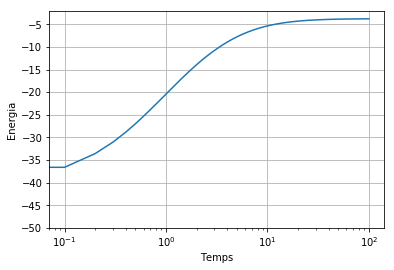

Energia final: -3.7710591789208476
Valor teòric: -3.743597548429035


In [8]:
#Crank-Nicolson per a la resolució de l'equació de Schrödinger en el temps

psi = ground_state
psi = psi/np.linalg.norm(psi) #Normalitzem

#Definim el temps inicial i final
t_inicial = 0
t_final = 100
dt = 0.1

#Definim el temps
temps = np.arange(t_inicial, t_final, dt)
vect_energy = []


productes_escalars = []

for t in temps:
    #Definim les matrius de propagació
    U_mes = np.identity(2**N) + 1j*dt/2.*H(t)
    U_menys = np.identity(2**N) - 1j*dt/2.*H(t)

    #Fem un pas de temps dt
    psi = np.linalg.solve(U_mes, np.dot(U_menys, psi))

    #Calculem l'energia
    energia = np.real(np.dot(np.conjugate(psi), np.dot(H(t), psi)))
    vect_energy.append(energia)

    #Calculem el producte escalar entre psi i el vector propi del ground state
    producte_escalar = np.linalg.norm((np.dot(np.conjugate(psi), vec_minH0)))**2
    productes_escalars.append(producte_escalar)

#Grafiquem l'energia en funció del temps amb l'eix x en escala logarítmica
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
plt.plot(temps, vect_energy)
plt.yticks(np.arange(-50,0,5))
plt.xlabel('Temps')
plt.ylabel('Energia')
plt.grid()
plt.ylim = (-40,0)
plt.show()

#Mostrem el valor final de l'energia
print("Energia final:", vect_energy[-1])
print("Valor teòric:", E_min)

Veiem que l'energia avança cap al ground-state. 

Una altra forma de comprovar si estem realitzant un procés adiabàtic és amb el producte escalar entre el vector propi del groundstate i el nostre vector. Idelment hauria d'avançar cap a 1.

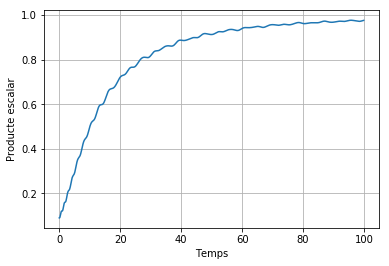

In [9]:
#Grafiquem els productes escalars en funció del temps
plt.plot(temps, productes_escalars)
plt.xlabel('Temps')
plt.ylabel('Producte escalar')
plt.grid()
plt.show()


## SIMULACIÓ DEL PROBLEMA DEL COMERCIANT AMB QUANTUM ANNEALING

Per simular el problema, haurem d'expressar el problema del comerciant com un Hamiltonià d'on volem trobar l'estat de mínima energia.
El problema del comerciant (en anglès: Travelling salesman problem) es pot enunciar de la següent forma: _Un comerciant ha de passar per N ciutats, de forma que només vol passar un cop per cada lloc, i vol trobar la ruta més curta. Aquesta ruta ha d'acabar a la mateixa ciutat on ha començat._

Matemàticament, podem formular el problema minimitzant la funció:

\begin{equation} 
    d = \sum_{i=1}^n \sum_{j \neq i, j=1}^n c_{i j} x_{i j}
\end{equation}

On d és la distància total del recorregut, $x_{ij}$ val 1 si les ciutats $i$ i $j$ estan connectades i 0 en cas contrari. Finalment, el coeficient $c_{ij}$ és el cost, normalment distància o temps, d'utlitzar el camí de la ciutat i a la j. Per tant, la funció sumarà totes les distàncies dels recorreguts entre nodes del recorregut proposat, ja que només pondera aquelles que $x_{ij} = 1$.

### Formulació QUBO del problema
 A partir de la formulació per grafs que hem plantejat, podem traduïr el problema a un Hamiltonià d'un Ising model, que després tindrà un anàleg amb qubits.

 Primer de tot, podem expressar les restriccions de no passar dos cops per la mateixa ciutat com:

\begin{aligned}
H_A =  A \sum_{v=1}^n\left(1-\sum_{j=1}^N x_{v, j}\right)^2+A \sum_{j=1}^n\left(1-\sum_{v=1}^N x_{v, j}\right)^2
 % +A \sum_{(u v) \notin E} \sum_{j=1}^N x_{u, j} x_{v, j+1} .
\end{aligned}


Que suposa una penalització d'energia de l'ordre de la constant $A>0$ si alguna s'incompleix. Els dos primers termes imposen que no passis dos cops per una ciutat, en cap de les dues direccions, ja que si només hi passes un cop, $\left(1-\sum_{j=1}^N x_{v, j}\right)^2 = 0$ i no hi ha la penalització energètica. 


La part del Hamiltonià que ens expressi la distància total recorreguda la podem expressar de forma anàloga a l'equació de la distància.

\begin{equation}
H_B=B \sum_{(u v) \in E} W_{u v} \sum_{j=1}^N x_{u, j} x_{v, j+1} .
\end{equation}

Finalment, el Hamiltonià total que haurem de traduir al nostre quantum annealer serà:

\begin{equation}
    H = H_A + H_B
\end{equation}

### De QUBO a ISING

Les variables en una formulació QUBO poden prendre els valors de 0 o 1. En canvi, en una formulació ISING poden prendre els valors de -1 o 1. Per a fer la transformació entre aquestes dues formulacions equivalents hem de tenir en compte que:

$$ x_{I,i} = 2x_{Q,i}-1  \xRightarrow{} x_Q = \frac{x_I+1}{2}$$

On $x_I$ són les variables en la formulació ISING i $x_Q$ en formulació QUBO. Per a traslladar-ho al sistema físic de qubits ens interessarà tenir el problema expressat com un ISING.

Les constants que ens apareixin tindran implícita una multiplicació per una Identitat de dimensió $2^N * 2^N$ on N és el nombre de ciutats del nostre problema.

### Aleatoritzem les ciutats

En un mapa 100x100


Ciutats: [[54.2, 18.0], [56.7, 56.2], [13.5, 29.9], [82.8, 86.9], [59.6, 37.7]]


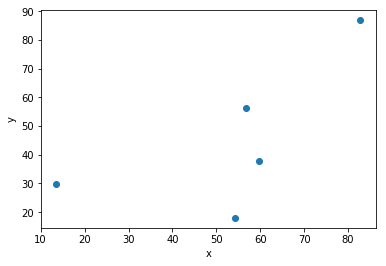

In [80]:
#Aleatoritzem les ciutats
x_mapa = 100
y_mapa = 100

# number of cities
N_ciutats = 5
n = N_ciutats

#Generem les coordenades x,y de les ciutats
x = np.random.randint(0, x_mapa*10, n)
x = x/10.
y = np.random.randint(0, y_mapa*10, n)
y = y/10.

#Ho posem tot a una llista
cities = []
for i in range(n):
    cities.append([x[i], y[i]])

print("Ciutats:", cities)

#Les representem en un gràfic
plt.plot(x, y, "o")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Matriu de distàncies

Distàncies: [[5.00000000e+04 3.82817189e+01 4.24040092e+01 7.46000670e+01
  2.04266982e+01]
 [3.82817189e+01 5.00000000e+04 5.05759824e+01 4.02951610e+01
  1.87259179e+01]
 [4.24040092e+01 5.05759824e+01 5.00000000e+04 8.97300953e+01
  4.67552136e+01]
 [7.46000670e+01 4.02951610e+01 8.97300953e+01 5.00000000e+04
  5.43955881e+01]
 [2.04266982e+01 1.87259179e+01 4.67552136e+01 5.43955881e+01
  5.00000000e+04]]


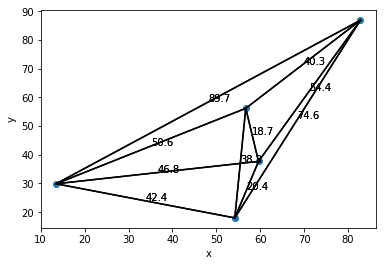

In [81]:
distancies = np.zeros((n,n))

#Calculem les distàncies entre totes les ciutats
for i in range(n):
    for j in range(n):
        distancies[i,j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
        if i == j:
            distancies[i,j] = 50000

print("Distàncies:", distancies)

#Fem un mapa de les ciutats amb les distàncies a les arestes
plt.plot(x, y, "o")
for i in range(n):
    for j in range(n):
        if i != j:
            plt.plot([x[i], x[j]], [y[i], y[j]], "k")
            plt.text((x[i]+x[j])/2., (y[i]+y[j])/2., str(round(distancies[i,j],1)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Resolució clàssica del problema per força bruta
Sumarem totes les possibilitats i triarem la millor

Permutació amb distància mínima: [2, 1, 3, 4, 0]
Distància mínima: 208.0974389586755


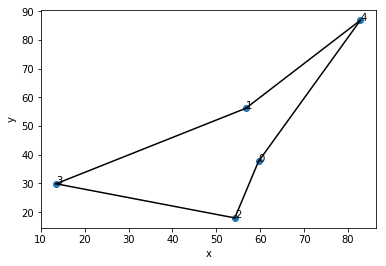

In [82]:
#Resolució per força bruta
#Generem totes les permutacions possibles
for i in range(n):
    if i == 0:
        permutacions = [[i]]
    else:
        permutacions_aux = []
        for cas in permutacions:
            for j in range(len(cas)+1):
                permutacions_aux.append(cas[:j]+[i]+cas[j:])
        permutacions = permutacions_aux

#Calculem la distància de cada permutació
distancies_permutacions = []
for cas in permutacions:
    dist = 0
    for i in range(n):
        dist += distancies[cas[i],cas[(i+1)%n]]
    distancies_permutacions.append(dist)

#Agafem la permutació amb la distància mínima
min_dist = min(distancies_permutacions)
min_perm = permutacions[distancies_permutacions.index(min_dist)]

print("Permutació amb distància mínima:", min_perm)
print("Distància mínima:", min_dist)

#Representem la permutació amb la distància mínima
plt.plot(x, y, "o")
for i in range(n):
    plt.text(x[i], y[i], str(min_perm[i]))
for i in range(n):
    plt.plot([x[min_perm[i]], x[min_perm[(i+1)%n]]], [y[min_perm[i]], y[min_perm[(i+1)%n]]], "k")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### Diferents formulacions ising de les combinacions

La que farem servir serà la darrera, amb variables +-1

In [79]:
#Possibles combinacions amb repeticio de n ciutats [1,1,1,1,...,1,1], [1,1,1,1,...,1,2], [1,1,1,1,...,1,3], ... , [n,n,n,n,...,n,n]

combinacions = n**n
permutacions = []
for i in range(combinacions):
    permutacions.append([i%n+1])   
    for j in range(n-1):
        permutacions[i].append(int(i/(n**(j+1)))%n+1)

permutacions.sort()
for i in range(combinacions):
    print(permutacions[i])

#Podem asignar a cada estat un valor binari en un vector de n**n posicions
#Per exemple, [1,1,1,...,1,1] -> [1,0,0,...,0,0]; [1,1,1,...,1,2] -> [0,1,0,...,0,0]; [1,1,1,...,1,3] -> [0,0,1,...,0,0]; ... ; [n,n,n,...,n,n] -> [0,0,0,...,0,1]
permutacions_binari = np.zeros((combinacions, combinacions))
permutacions_binari = np.eye(combinacions)

# print(permutacions_binari)

#També podem passar els estats directament a les variables que hem fet servir en la formulació
#d'Ising model. D'aquesta manera, cada estat tindrà definida com a +-1 les variables x^i_{jk} de forma que 
#Serà igual a 1 si a la iteració i, es va de la ciutat j a la k, i -1 en tots els altres casos.

ciutats = []
for i in range(n):
    ciutats.append(i+1)
print(ciutats)

permutacions_ising = np.zeros((combinacions, n**2))
#Restem 1 a les permutacions_ising per tenir -1 per defecte enlloc de 0

permutacions_ising = permutacions_ising - 1

# print(permutacions_ising)

print(len(permutacions))
# print(len(permutacions_ising))
for i in range(len(permutacions)):
    for j in range(n):
        permutacio = permutacions[i]

        if j == 0:
            city1 = permutacio[n-1]
        else:
            city1 = permutacio[j-1]

        city2 = permutacio[j]

        print(i, j, city1, city2, n*(city1-1) + city2-1 + j*n**2)
        permutacions_ising[i][n*(city1-1) + city2-1 + j*n**2] = 1

print(permutacions_ising)


[1, 1]
[1, 2]
[2, 1]
[2, 2]
[1, 2]
4
0 0 1 1 0
0 1 1 1 4


IndexError: index 4 is out of bounds for axis 0 with size 4

### Variables (Spins) necessaris en funció del nombre de ciutats
Veiem que creix com $n^3$

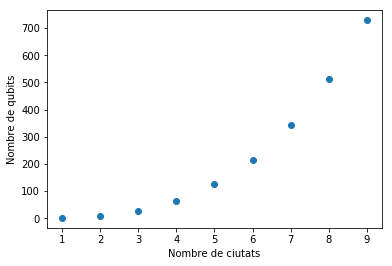

In [78]:
#Grafiquem el nombre de variables x^i_{jk} en funció de les ciutats
def nombre_variables(nombre_ciutats):
    return nombre_ciutats**3

x = np.arange(1, 10, 1)
y = nombre_variables(x)
plt.plot(x, y, "o")
plt.xlabel('Nombre de ciutats')
plt.ylabel('Nombre de qubits')
plt.show()


### Ampliem la matriu de distàncies

S'haurà de repetir per cada cop que viatgem d'una ciutat a una altra. Això ho podem fer multiplicant per identitats

In [74]:
#Multipliquem la matriu de distàncies per tantes identitats com ciutats tinguem.
#Això ens permetrà multiplicar cada element de la matriu de distàncies per una variable x^i_{jk}

identitat = np.eye(n)
distancies_ising = distancies
for i in range (n):
    distancies_ising = np.kron(identitat, distancies_ising )

print(distancies_ising)

[[50000.            95.92048791     0.             0.
      0.             0.             0.             0.        ]
 [   95.92048791 50000.             0.             0.
      0.             0.             0.             0.        ]
 [    0.             0.         50000.            95.92048791
      0.             0.             0.             0.        ]
 [    0.             0.            95.92048791 50000.
      0.             0.             0.             0.        ]
 [    0.             0.             0.             0.
  50000.            95.92048791     0.             0.        ]
 [    0.             0.             0.             0.
     95.92048791 50000.             0.             0.        ]
 [    0.             0.             0.             0.
      0.             0.         50000.            95.92048791]
 [    0.             0.             0.             0.
      0.             0.            95.92048791 50000.        ]]


## HAMILTONIÀ DEL TSP

In [75]:
N_spins = N_ciutats**3

#Definim l'hamiltonià del problema del viatjant 
#Per resoldre'l amb simulació de quantum annealing
#Tindrà dues parts, la de restricció i la de distància
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])

#Part de restricció, on A és el pes de la restricció
#Hem de tenir en compte que hi ha productes tensorials implícits
A=1000
def H_restriccio(A):
    H = np.zeros((2**N_spins, 2**N_spins))
    #Sumem per totes les i
    for i in range(N_spins-1):
        for j in range(i,N_spins):
            mJ = np.identity(1)
            for k in range(N_spins):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H += (1-mJ)*(1-mJ)
    #Ara sumem per totes les j
    for j in range(N_spins-1):
        for i in range(i,N_spins):
            mJ = np.identity(1)
            for k in range(N_spins):
                if k == i:
                    mJ = np.kron(mJ, sigma_z)
                elif k == j:
                    mJ = np.kron(mJ, sigma_z)
                else:
                    mJ = np.kron(mJ, identitat)
            H += (1-mJ)*(1-mJ)
    return H*A


    


In [76]:
#Part de distància, on B és el pes de la distància
#Hem de tenir en compte que hi ha productes tensorials implícits
B=1
def H_distancia(B):
    H = np.zeros((2**N_spins, 2**N_spins))
    for i in range(N_spins):
        for j in range(N_spins):
            if i != j:
                mJ = np.identity(1)
                for k in range(N_spins):
                    if k == i:
                        mJ = np.kron(mJ, sigma_z)
                    elif k == j:
                        mJ = np.kron(mJ, sigma_z)
                    else:
                        mJ = np.kron(mJ, identitat)
                print(i,j,k)
                H += distancies_ising[i,j]*mJ
    return H*B

H0_TSP = H_distancia(B) + H_restriccio(A)
vals_H0_TSP, vecs_H0_TSP = np.linalg.eigh(H0_TSP)

print ("Energies: ", vals_H0_TSP)
print ("Vectors propis del ground state: ", vecs_H0_TSP)



0 1 7
0 2 7
0 3 7
0 4 7
0 5 7
0 6 7
0 7 7
1 0 7
1 2 7
1 3 7
1 4 7
1 5 7
1 6 7
1 7 7
2 0 7
2 1 7
2 3 7
2 4 7
2 5 7
2 6 7
2 7 7
3 0 7
3 1 7
3 2 7
3 4 7
3 5 7
3 6 7
3 7 7
4 0 7
4 1 7
4 2 7
4 3 7
4 5 7
4 6 7
4 7 7
5 0 7
5 1 7
5 2 7
5 3 7
5 4 7
5 6 7
5 7 7
6 0 7
6 1 7
6 2 7
6 3 7
6 4 7
6 5 7
6 7 7
7 0 7
7 1 7
7 2 7
7 3 7
7 4 7
7 5 7
7 6 7
Energies:  [-4.19155715e+04 -1.40418746e+04 -6.61631805e+03 -6.61631805e+03
 -6.61631805e+03 -6.61631805e+03 -5.75020434e+03 -2.61631805e+03
 -2.17633606e+03  1.33836820e+04  1.33836820e+04  1.33836820e+04
  1.33836820e+04  1.33836820e+04  1.40222258e+04  1.73836820e+04
  1.75773277e+04  2.10000000e+04  2.10000000e+04  2.10000000e+04
  2.10000000e+04  2.10000000e+04  2.10000000e+04  2.10000000e+04
  2.10000000e+04  2.15028481e+04  2.17673639e+04  2.22366973e+04
  2.50000000e+04  2.50000000e+04  2.50000000e+04  2.50000000e+04
  2.50000000e+04  2.50000000e+04  2.50000000e+04  2.50000000e+04
  2.56175437e+04  2.62980367e+04  3.30000000e+04  3.30000000e+04
  3

In [16]:
#Afegim el terme gamma
def H_gamma(t):
    gamma = 10./(t+1.)
    for i in range(N):
        mgamma = np.identity(1)
        for j in range(N):
            if j == i:
                mgamma = np.kron(mgamma, sigma_x)
            else:
                mgamma = np.kron(mgamma, identitat)

    return gamma*mgamma


#Definim l'hamiltonià total
def H_total(A,B,t):
    return H_restriccio(A) + H_distancia(B) + H_gamma(t)

print("Hamiltonià de restricció:", H_restriccio(1000))
print("Hamiltonià de distància:", H_distancia(1))
print("Hamiltonià total:", H_total(1000,1,0))

Hamiltonià de restricció: [[    0. 26000. 26000. ... 26000. 26000. 26000.]
 [26000. 40000. 26000. ... 26000. 26000. 26000.]
 [26000. 26000. 32000. ... 26000. 26000. 26000.]
 ...
 [26000. 26000. 26000. ... 44000. 26000. 26000.]
 [26000. 26000. 26000. ... 26000. 60000. 26000.]
 [26000. 26000. 26000. ... 26000. 26000. 20000.]]
Hamiltonià de distància: [[1085.1900998     0.            0.         ...    0.
     0.            0.        ]
 [   0.          496.44322484    0.         ...    0.
     0.            0.        ]
 [   0.            0.          280.88528549 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  280.88528549
     0.            0.        ]
 [   0.            0.            0.         ...    0.
   496.44322484    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1085.1900998 ]]
Hamiltonià total: [[ 1085.1900998  26010.         26000.         ... 26000.
  26000.         26000.        ]
 [26010.        

In [17]:
H0_TSP = H_total(1000,1,0)

#Diagonalitzem H0 per obtenir els valors propis i els vectors propis
valors_propis, vectors_propis = np.linalg.eigh(H0_TSP)

print("Energies:", valors_propis)


#Guardem l'estat propi del ground state al temps inicial
ground_energy_TSP = np.amin(valors_propis)
ordre = np.argsort(valors_propis)

ground_state_TSP = vectors_propis[:,ordre[0]]

print ("Energia propia del ground state:", ground_energy_TSP)
print("Estat propi del ground state:", ground_state_TSP)

Energies: [ -24175.9597863    -4494.92596485    2318.071442      2454.55083139
    3400.97762451    6248.98616774    7130.8928436    14317.04787405
   14409.96240432   14517.2579025    15431.77939586   18248.19454551
   18738.2027959    21923.01488372   21981.56692303   22037.87261129
   22643.08048876   25538.70002088   25732.09133293   25893.532278
   25906.20340963   25913.93949743   25939.08334484   25972.7310587
   26007.33281939   26016.53067406   26030.73703819   26042.94663975
   26053.29260995   27749.61244716   29534.91584698   29643.46661053
   29739.43928466   29872.75577385   29890.14500307   29904.78548716
   29923.3318699    29932.71842204   29982.12480159   30008.22756516
   30038.13025702   32133.3849358    33559.66837666   33597.22292109
   33654.46457383   33744.06081983   33868.0785033    33879.47797766
   33892.33562957   33919.86003439   33935.7950221    34440.84582499
   36588.69431973   37562.10703654   37632.43434878   37749.1274752
   37878.16657971   37900.92

In [18]:
#Afegim un terme ortogonoal que evolucioni amb el temps
#Per tal de fer la simulació de quantum annealing
#Crank-Nicolson per a la resolució de l'equació de Schrödinger en el temps

psi = ground_state_TSP
psi = psi/np.linalg.norm(psi) #Normalitzem

#Definim el temps inicial i final
t_inicial = 0
t_final = 100
dt = 0.1

#Definim el temps
temps = np.arange(t_inicial, t_final, dt)
vect_energy = []


productes_escalars = []

A = 1000
B = 1

for t in temps:
    #Definim les matrius de propagació
    U_mes = np.identity(2**N) + 1j*dt/2.*H_total(A,B,t)
    U_menys = np.identity(2**N) - 1j*dt/2.*H_total(A,B,t)

    #Fem un pas de temps dt
    psi = np.linalg.solve(U_mes, np.dot(U_menys, psi))

    #Calculem l'energia
    energia = np.real(np.dot(np.conjugate(psi), np.dot(H_total(A,B,t), psi)))
    vect_energy.append(energia)

    #Calculem el producte escalar entre psi i el vector propi del ground state
    producte_escalar = np.linalg.norm((np.dot(np.conjugate(psi), g)))**2
    productes_escalars.append(producte_escalar)

#Grafiquem l'energia en funció del temps amb l'eix x en escala logarítmica
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.set_xscale('log')
plt.plot(temps, vect_energy)
plt.yticks(np.arange(-50,0,5))
plt.xlabel('Temps')
plt.ylabel('Energia')
plt.grid()
plt.ylim = (-40,0)
plt.show()

#Mostrem el valor final de l'energia
print("Energia final:", vect_energy[-1])
print("Valor teòric:", E_min)


NameError: name 'g' is not defined

## REFERÈNCIES

Quantum Annealing in the transverse Ising Model, Óscar Promio MuÑnoz